In [1]:
%matplotlib inline
import sys
sys.path.append('.')
sys.path.append('..')
sys.path.append('../coco-caption')
import torch
import matplotlib.pyplot as plt
from dataloader import get_loader
from models import Model
from config import Constants
from torchvision.transforms import Compose, Resize, CenterCrop
import os

init COCO-EVAL scorer


In [2]:
def get_model_and_device(checkpoint_path, device=None, strict=True, new_opt_used_to_override={}, **kwargs):
    if device is None:
        if torch.cuda.is_available():
            device = torch.device('cuda')
        else:
            device = torch.device('cpu')
    elif type(device) is str:
        device = torch.device(device)
    else:
        raise ValueError()
    
    model = Model.load_from_checkpoint(
        checkpoint_path, 
        map_location=device,
        strict=strict,
        new_opt_used_to_override=new_opt_used_to_override
    )
    model.eval()
    
    return model, device


def print_pred_caption(model, device, loader, vid, specific_image_positions = [], **kwargs):
    batch = loader.dataset.get_specific_data_by_vid_and_cap_id(vid, 0, device=device)
    if len(specific_image_positions):
        batch['feats'] = [item[:, specific_image_positions] for item in batch['feats']]

    with torch.no_grad():
        outputs = model.translate_step(batch=batch, vocab=model.get_vocab(), assert_only_a_caption_per_video=True)
        pred_caption = outputs[vid][0]['caption']

    print(pred_caption)

def print_all_captions_of_a_vid(loader, vid):
    all_captions = loader.dataset.get_preprocessed_gt_sentences_by_vid(vid, add_special_tokens=False)

    for i, cap in enumerate(all_captions):
        print('{:3d} {:s}'.format(i, cap))

In [3]:
def show(images_to_show, title='', figsize=(15, 6), n_row=4, n_col=7, save_path='', save_name=''):
    fig = plt.figure(figsize=figsize)
    if title:
        plt.title(title)

    for i in range(len(images_to_show)):
        ax = plt.subplot(n_row, n_col, i+1)
        ax.imshow(images_to_show[i])
        ax.set_yticks([])
        ax.set_xticks([])

    plt.subplots_adjust(wspace=0, hspace=0.05)
    if save_path:
        assert save_name
        os.makedirs(save_path, exist_ok=True)
        path = os.path.join(save_path, save_name)
        plt.savefig(path, dpi=300)
    plt.show()

def visualize_images(vid, loader, transform=Compose([Resize(224), CenterCrop((224, 224))]), specific_image_positions=[], **kwargs):
    images = loader.dataset.get_video_frames_by_vid(vid, all_frames_path='../../../new_VC_data/MSRVTT/all_frames')
    if transform is not None:
        for i in range(len(images)):
            images[i] = transform(images[i])
    if len(specific_image_positions):
        images = [image for pos, image in enumerate(images) if pos in specific_image_positions]
    show(images, **kwargs)

def visualize_attribute_predictions(model, device, loader, vid, cid=0, text=None, topk=5, flag='V'):
    model.eval()
    container = model.captioner.predictor.nets[0]
    
    with torch.no_grad():
        batch = loader.dataset.get_specific_data_by_vid_and_cap_id(vid, cid, text=text)
        results = model.captioner(batch)

        if flag == 'V':
            feats = results['encoder_hidden_states']
            mask = None
        else:
            assert flag == 'I'
            feats = model.captioner.decoder.get_sentence_embeddings(batch['input_ids'], average_pooling=False)
            mask = batch['labels'].eq(Constants.PAD)
        
        topk_probs, topk_indices = container.get_topk_attribute_predictions(feats, mask=mask, topk=topk, flag=flag)

    vocab = model.get_vocab()
    for p, i in zip(topk_probs[0].numpy(), topk_indices[0].numpy()):
        print(i, vocab[i + Constants.attribute_start], p)

In [4]:
CLIP_Base, device = get_model_and_device(
    checkpoint_path='../exps/MSRVTT/Transformer/diff_feats/ViT_ami/best.ckpt',
    device='cpu',
    strict=True
)
CLIP_DAP, device = get_model_and_device(
    checkpoint_path='../exps/MSRVTT/Transformer/DAP/attr500_ViT_ami/best.ckpt',
    device='cpu',
    strict=True
)
loader = get_loader(
    CLIP_Base.get_opt(), 
    mode='test',
    not_shuffle=True, 
    is_validation=True
)

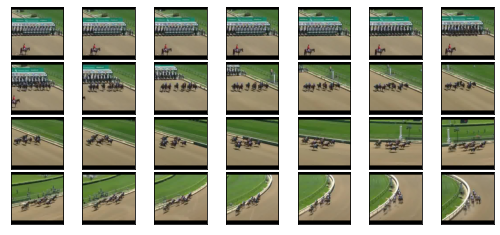

  0 a group of horses are racing at a track
  1 a group of horses are racing on a track
  2 a group of <unk> on the tracks
  3 a horse race is happening
  4 a horse race on nbc
  5 a horse race on nbc
  6 horse race is going on in a race course
  7 horse race on nbc
  8 horse racing derby run
  9 horses are running on a track for a race
 10 horses begin to race at <unk> downs
 11 horses leap out of the gate in a race
 12 horses race down a track with no audio
 13 horses races down a track for a sporting event
 14 its horse riding show
 15 people are racing horses on a track
 16 professional coverage of a horse race
 17 some horses are racing
 18 video of people horse racing
 19 horses begin to race at <unk> downs
----------------------------------------
people are riding horses
people are riding horses
----------------------------------------
95 horse 0.9998542
97 riding 0.9992833
135 race 0.9837573
288 racing 0.9629994
166 track 0.95578396
449 horses 0.9317418
6 people 0.9280569
10 me

../misc/Crit/crit_attribute.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  threshold = torch.tensor(n_positive / n_attributes).to(device)


In [5]:
vid = 'video9376'
visualize_images(vid, loader, figsize=(9, 4))
print_all_captions_of_a_vid(loader, vid)
print('-' * 40)
print_pred_caption(CLIP_Base, device, loader, vid)
print_pred_caption(CLIP_DAP, device, loader, vid)
print('-' * 40)
visualize_attribute_predictions(CLIP_DAP, device, loader, vid, topk=10)

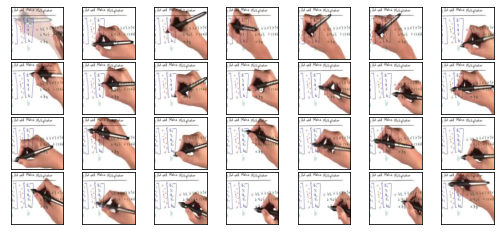

  0 a male voice explains how to solve a math problem
  1 the man talks about how to <unk> the <unk> in a simple way
  2 a man is doing a multiple table for its viewers
  3 a man is explaining <unk> and writing with a pen
  4 a man showing how to do math on a projector
  5 two <unk> are used to demonstrate a type of <unk>
  6 a man is writing in the white board and explain about it
  7 explaining about <unk> <unk>
  8 a hand is holding a pen and demonstrating a math problem
  9 an explanation of how to perform a <unk> equation
 10 a man is showing how to solve a math problem
 11 a teacher shows how to <unk> the dot product of two <unk>
 12 a person writing on white board mathematical equation solving problem displaying on screen
 13 a guy explains how to find the product of 2 <unk>
 14 an <unk> <unk> math problem sits upon the screen as a hand holding a pen attempts to solve the problem
 15 a man writes out numbers on a screen to teach a lesson
 16 a person explaining a particular type

In [6]:
vid = 'video7775'
visualize_images(vid, loader, figsize=(9, 4))
print_all_captions_of_a_vid(loader, vid)
print('-' * 40)
print_pred_caption(CLIP_Base, device, loader, vid)
print_pred_caption(CLIP_DAP, device, loader, vid)
print('-' * 40)
visualize_attribute_predictions(CLIP_DAP, device, loader, vid, topk=10)

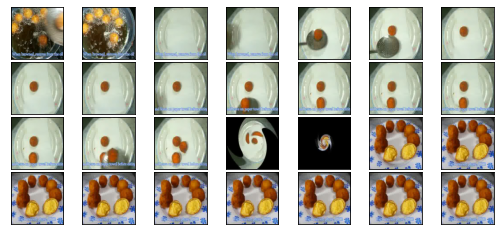

  0 a cooked dish is spooned onto a plate
  1 a man describes how to brown some food and cook it
  2 a person fries balls in oil
  3 a person is cooking
  4 a person is <unk> fried food
  5 a person is removing pieces of cooked food from a boiling pot and placing them on a decorative plate
  6 a person is telling about food
  7 a person places some food on a plate
  8 a person removing food from a pan
  9 a person shows how to make cheese <unk>
 10 a woman is showing how to cook
 11 fried dumplings are removed from the oil they re cooking in
 12 how to fry <unk> puppies
 13 person frying bread and putting it on a plate
 14 serving fried food on paper towel
 15 someone is cooking food and putting it on a plate
 16 someone is cooking in hot oil
 17 someone is frying food
 18 someone is making a fried treat over the stove
 19 someone is removing fried foods from oil
----------------------------------------
a person is preparing food
a person is putting some food on a plate
---------------

In [7]:
vid = 'video7973'
visualize_images(vid, loader, figsize=(9, 4))
print_all_captions_of_a_vid(loader, vid)
print('-' * 40)
print_pred_caption(CLIP_Base, device, loader, vid)
print_pred_caption(CLIP_DAP, device, loader, vid)
print('-' * 40)
visualize_attribute_predictions(CLIP_DAP, device, loader, vid, topk=10)

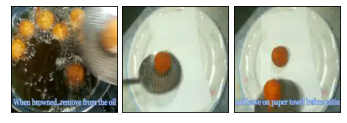

In [8]:
vid = 'video7973'
visualize_images(vid, loader, figsize=(6, 1.95), specific_image_positions=[0, 4, 10], n_row=1, n_col=3, save_path='./qualitative_figs', save_name='%s.png'%vid)

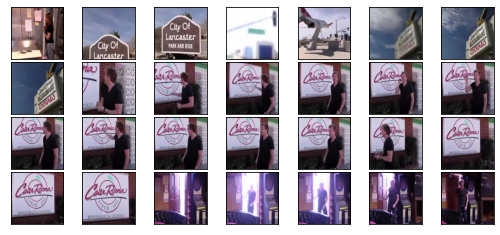

  0 a man in blue t-shirt is excitedly saying something and dancing
  1 a city sign an airplane and a man walking into a room
  2 gordon ramsey shows up to <unk> <unk> in the city of lancaster to see what the restaurant looks like inside
  3 a man in black reads the name of the restaurant and happily enters it
  4 a lady is wearing black shirt and entering in the room
  5 chef <unk> ramsay is preparing to inspect a restaurant to grade
  6 a guy <unk> about how old a restaurant is and then going inside
  7 in the city of lancaster at a park and ride side a black dressed gentleman enters into a restaurant <unk> <unk> <unk> opened in <unk>
  8 this man is <unk> by the age of this eating establishment
  9 in the city of lancaster chef <unk> ramsey describes the sign of <unk> <unk> than proceeds inside
 10 a man talking about something and getting into a room
 11 someone checking out a restaurant that was built quite some time ago looking to see if any <unk> have been made since
 12 tv chef

In [9]:
vid = 'video8555'
visualize_images(vid, loader, figsize=(9, 4))
print_all_captions_of_a_vid(loader, vid)
print('-' * 40)
print_pred_caption(CLIP_Base, device, loader, vid)
print_pred_caption(CLIP_DAP, device, loader, vid)
print('-' * 40)
visualize_attribute_predictions(CLIP_DAP, device, loader, vid, topk=10)

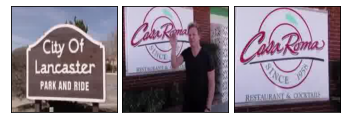

In [10]:
vid = 'video8555'
visualize_images(vid, loader, figsize=(6, 1.95), specific_image_positions=[2, 13, 22], n_row=1, n_col=3, save_path='./qualitative_figs', save_name='%s.png'%vid)

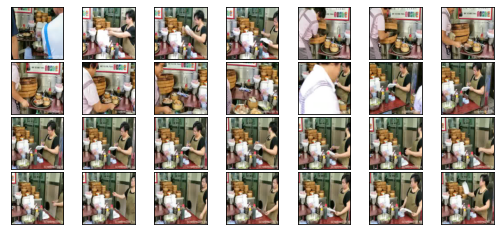

  0 a man takes a platter of food to be served
  1 a recipe is prepared
  2 a woman is cooking
  3 a woman is serving dishes
  4 a woman is serving food
  5 a woman is writing on a piece of paper while someone carries out food
  6 a woman prepares some food for customers in a restaurant
  7 a woman preparing food in a kitchen while another woman writes
  8 a woman serves street food
  9 food is prepared and put on a tray
 10 food services workers putting together plates of food
 11 it is a scene from inside a restaurant as food is prepared
 12 lady is busy preparing food
 13 person is preparing some food
 14 someone is serving food in the <unk>
 15 this is a video of a woman serving food
 16 woman preparing food to be served
 17 woman serves pastries and food
 18 lady is busy preparing food
 19 someone is serving food in the <unk>
----------------------------------------
a person is preparing food in the kitchen
a man is cooking food in a restaurant
------------------------------------

In [11]:
vid = 'video9107'
visualize_images(vid, loader, figsize=(9, 4))
print_all_captions_of_a_vid(loader, vid)
print('-' * 40)
print_pred_caption(CLIP_Base, device, loader, vid)
print_pred_caption(CLIP_DAP, device, loader, vid)
print('-' * 40)
visualize_attribute_predictions(CLIP_DAP, device, loader, vid, topk=10)

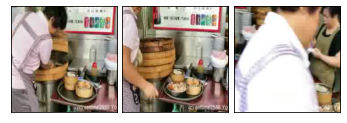

In [12]:
vid = 'video9107'
visualize_images(vid, loader, figsize=(6, 1.95), specific_image_positions=[4, 7, 11], n_row=1, n_col=3, save_path='./qualitative_figs', save_name='%s.png'%vid)

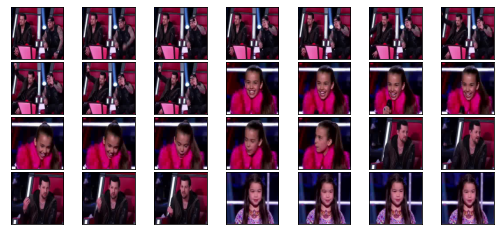

  0 a girl being judged
  1 a girl is laughing on stage
  2 a judge gives a thumbs up to a girl
  3 a little girl is being critiqued on the voice
  4 a man is critiquing the performance to at least two little girls on a television show
  5 a man is talking to a girl standing in a stage
  6 a panel of judges is talking to a girl
  7 a scene from the voice
  8 a talent search show starring a good <unk>
  9 a video with two men talking about a girls performance
 10 girls get feedback on a talent show
 11 judges and a family cheer on the voice
 12 judges give positive reviews to young singers
 13 judges review the performance of young girls
 14 the clip is from a talent tv show involving children
 15 the judges were impressed
 16 this is a video from the voice kids
 17 <unk> singer judged by judges
 18 young girls perform on the voice
 19 a little girl is being critiqued on the voice
----------------------------------------
a girl is talking to a group of people
a girl is talking to a pane

In [13]:
vid = 'video9298'
visualize_images(vid, loader, figsize=(9, 4))
print_all_captions_of_a_vid(loader, vid)
print('-' * 40)
print_pred_caption(CLIP_Base, device, loader, vid)
print_pred_caption(CLIP_DAP, device, loader, vid)
print('-' * 40)
visualize_attribute_predictions(CLIP_DAP, device, loader, vid, topk=10)

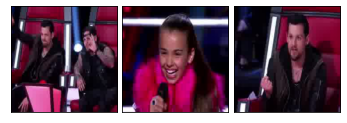

In [14]:
vid = 'video9298'
visualize_images(vid, loader, figsize=(6, 1.95), specific_image_positions=[6, 12, 23], n_row=1, n_col=3, save_path='./qualitative_figs', save_name='%s.png'%vid)

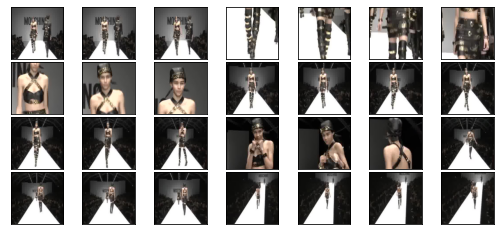

  0 a few female models walking <unk> on a ramp of a fashion show of <unk> company
  1 a lady walks the catwalk
  2 a model is walking down the runway at a fashion show
  3 a woman is walking down a catwalk
  4 it is about a fashion show
  5 modeling show for girls
  6 models are walking down a runway
  7 models are walking down a runway
  8 models are walking on a catwalk
  9 models in a catwalk on ramp
 10 models walk down a white runway in black and gold outfits
 11 models walk the runway during a fashion show
 12 people walk on a cat walk in strange uniforms
 13 <unk> strut on a catwalk above an <unk> crowd
 14 the beautiful woman walks the catwalk and <unk>
 15 woman are modeling clothes
 16 women are walking down the runway at a <unk> fashion show
 17 women are walking down the runway
 18 women walking the runway in a fashion show
 19 models walk the runway during a fashion show
----------------------------------------
a woman is walking down a runway
models are walking down a ru

In [15]:
vid = 'video8065'
visualize_images(vid, loader, figsize=(9, 4))
print_all_captions_of_a_vid(loader, vid)
print('-' * 40)
print_pred_caption(CLIP_Base, device, loader, vid)
print_pred_caption(CLIP_DAP, device, loader, vid)
print('-' * 40)
visualize_attribute_predictions(CLIP_DAP, device, loader, vid, topk=10)

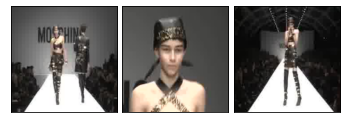

In [16]:
vid = 'video8065'
visualize_images(vid, loader, figsize=(6, 1.95), specific_image_positions=[2, 9, 16], n_row=1, n_col=3, save_path='./qualitative_figs', save_name='%s.png'%vid)

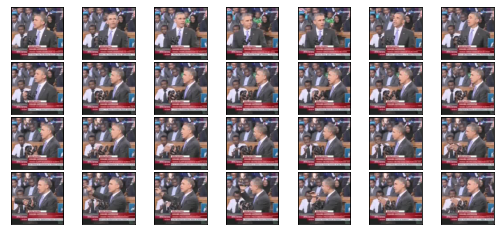

  0 a clip showcasing the president giving a speech
  1 a man is giving a speech
  2 a news channel is telecasting barack obama s speech
  3 barack obama is speaking to a large group in <unk>
  4 cartoons are talking to each otehr
  5 obama addresses the nation with a speech
  6 obama giving a speech about economy
  7 obama is talking in front of people
  8 obama makes a speech about <unk>
  9 obama talked about south korea vs <unk> economy
 10 president obama addressing <unk> about economic differences
 11 president obama giving an address
 12 president obama is giving a speach
 13 president obama makes a speech before the us congress
 14 president obama talking about a political situation
 15 president talking of two nations
 16 scene from a political conference
 17 the american president giving a speech on <unk>
 18 the president of the united states is giving a speech to a crowd
 19 obama addresses the nation with a speech
----------------------------------------
president obama is

In [17]:
vid = 'video7619'
visualize_images(vid, loader, figsize=(9, 4))
print_all_captions_of_a_vid(loader, vid)
print('-' * 40)
print_pred_caption(CLIP_Base, device, loader, vid)
print_pred_caption(CLIP_DAP, device, loader, vid)
print('-' * 40)
visualize_attribute_predictions(CLIP_DAP, device, loader, vid, topk=10)

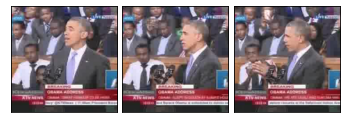

In [18]:
vid = 'video7619'
visualize_images(vid, loader, figsize=(6, 1.95), specific_image_positions=[6, 13, 20], n_row=1, n_col=3, save_path='./qualitative_figs', save_name='%s.png'%vid)